In [2]:
import numpy as np
from atom import *

读取XDATCAR文件，步长为2fs

In [3]:
LiF = loadfile(2)

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


制作测试集

In [4]:
train_data = np.array([np.array(np.append(LiF["F"].position[i],LiF["Li"].position[i])) for i in range(len(LiF["F"].position))])

In [5]:
import torch
import torch.nn as nn
import numpy as np

In [6]:
def diff(data):
    #输入train data并差分
    v = []
    for i in range(1,len(data)):
        v.append(data[i]-data[i-1])
    #print(v)
    return v

v = diff(train_data)

In [7]:
#print(train_data[1])

用前一帧的路径去预测下一帧速度

In [8]:
fwd = 1

class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.layer1 = nn.Linear(62*3*fwd, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 62*3)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = self.layer3(x)
        return x

In [9]:
# Create a MyDNN instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyDNN().to(device)

num_epochs = 1000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_array = []   #draw picture

# Train the model
for epoch in range(num_epochs):
    # Get the input and target arrays
    
    input_array = torch.from_numpy(train_data[epoch:epoch+fwd].reshape(-1)).float().to(device)
    target_array = torch.from_numpy(v[epoch+fwd-1].reshape(-1)).float().to(device)   #train_data+1 v不加
    #print(epoch,input_array,target_array)
    # Forward pass
    output_array = model(input_array)

    # Compute the loss
    loss = criterion(output_array, target_array)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
    loss_array.append(loss.item())

Epoch [50/1000], Loss: 0.002869386
Epoch [100/1000], Loss: 0.000712415
Epoch [150/1000], Loss: 0.000622251
Epoch [200/1000], Loss: 0.000757618
Epoch [250/1000], Loss: 0.000681380
Epoch [300/1000], Loss: 0.000534995
Epoch [350/1000], Loss: 0.000779774
Epoch [400/1000], Loss: 0.000647476
Epoch [450/1000], Loss: 0.000728055
Epoch [500/1000], Loss: 0.000791048
Epoch [550/1000], Loss: 0.000731650
Epoch [600/1000], Loss: 0.000696203
Epoch [650/1000], Loss: 0.000637813
Epoch [700/1000], Loss: 0.000598792
Epoch [750/1000], Loss: 0.000836150
Epoch [800/1000], Loss: 0.000658065
Epoch [850/1000], Loss: 0.000728815
Epoch [900/1000], Loss: 0.000726385
Epoch [950/1000], Loss: 0.000619405
Epoch [1000/1000], Loss: 0.000708698


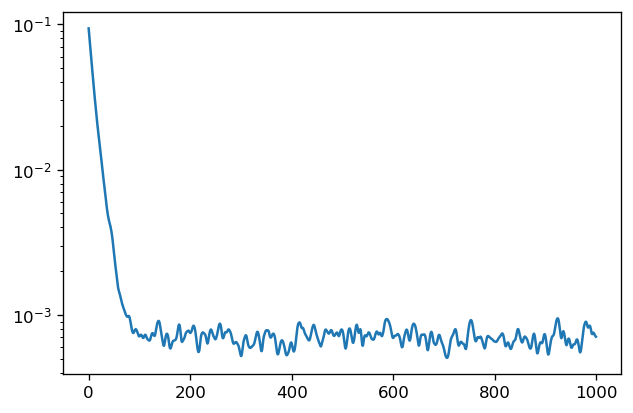

In [10]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

# 把最后一帧的速度作为输出和目标进行一个对比

In [11]:
#
print(output_array)
print(target_array)
print(criterion(output_array, target_array))

tensor([ 1.3333e-02, -1.2462e-02,  6.5117e-03,  4.4968e-03,  2.3479e-03,
         9.1498e-03,  3.7178e-03,  2.2302e-03, -6.7349e-03,  2.1549e-02,
        -5.1223e-03,  1.3281e-02, -7.3222e-03, -1.1014e-02, -3.6061e-03,
         4.2944e-03, -1.5348e-02, -2.4620e-04, -7.0573e-03,  2.0518e-02,
         9.5082e-03,  6.3325e-03,  1.3754e-02,  2.5496e-02, -9.8080e-03,
        -1.8053e-02,  7.5909e-03,  7.4051e-03,  4.8256e-03,  3.5455e-03,
         1.6909e-02,  8.6824e-03, -1.9104e-02,  2.8923e-02, -1.5418e-02,
         1.5254e-02, -5.9427e-03, -1.3152e-03, -4.6470e-03,  6.7360e-03,
         1.8102e-03,  2.1917e-02, -1.5809e-02, -1.0134e-02, -6.3524e-03,
         8.5189e-03,  1.8206e-02,  2.6772e-03, -4.2569e-03,  3.5179e-02,
        -7.6944e-03, -3.4199e-03,  1.2650e-03,  1.0034e-02, -3.4708e-02,
        -9.7864e-03,  7.1732e-03, -1.4181e-02, -9.3445e-03, -2.4453e-02,
         8.5077e-03,  1.6992e-03, -2.3598e-02,  2.9024e-05,  5.3197e-03,
         2.2342e-03, -2.1843e-02, -8.6844e-03, -6.3

用frame的前五帧预测下一帧

In [9]:
# Get the input array for prediction
frame = 200
input_array = torch.from_numpy(train_data[frame-1:frame].reshape(-1)).float().to(device)

# Predict the output array
with torch.no_grad():
    output_array = model(input_array)

# Convert the output tensor to a numpy array
output_array = output_array.cpu().numpy() + train_data[frame-1:frame].reshape(-1)

In [144]:
#print(output_array.reshape(-1,3))

In [145]:
import ase
from ase.io import read ,write
from ase.build import sort
from ase.visualize import view

# 将某一帧写出

In [12]:
"""with open('LiF.vasp', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    f.write("Direct\n")
    for i in output_array.reshape(-1,3):
        f.write(str(i)[1:-1]+"\n")
bulk = read("LiF.vasp")
view(bulk)"""

'with open(\'LiF.vasp\', \'w\') as f:\n    f.write("vasp\n")\n    f.write("1.0\n")\n    for i in (LiF["F"].lattice):\n        f.write(str(i)[1:-1]+"\n")\n    for (i,j) in LiF.items():\n        f.write(j.name + " ")\n    f.write("\n")\n    for (i,j) in LiF.items():\n        f.write(str(j.number) + " ")\n    f.write("\n")\n    f.write("Direct\n")\n    for i in output_array.reshape(-1,3):\n        f.write(str(i)[1:-1]+"\n")\nbulk = read("LiF.vasp")\nview(bulk)'

# 跑100步写成xdatcar00

In [13]:
running_test = []
running_test.append(train_data[1000].tolist())

In [16]:
#def pbc_res(frame):
#    #在更新位置时考虑周期性边界条件
#    frame[frame < 0] += 1
#    frame[frame > 1] -= 1
#    return np.array(frame)

for i in range(100):
    input_array = torch.from_numpy(np.array(running_test[-1]).reshape(-1)).float().to(device)
    with torch.no_grad():
        output_array = model(input_array)
    running_test.append(output_array.cpu().numpy() + np.array(running_test[-1]).reshape(-1))
with open('XDATCAR00', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    for i in range(len(running_test)):
        f.write("Direct configuration=       "+str(i+1)+"\n")
        for j in np.array(running_test[i]).reshape(-1,3):
            f.write(str(j)[1:-1]+"\n")    